# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_149  Q9UQM7                     17.017
Sample_068  P52799                     16.308
Sample_049  J3KNA1;Q12840              16.799
Sample_134  P68036;P68036-2;P68036-3   15.379
Sample_059  Q99972                     15.068
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups          
Sample_156  Q8N3G9;Q8N3G9-2            12.633
Sample_178  Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.229
Sample_115  A0A0G2JIW1;P0DMV8;P0DMV9   15.721
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.312
            A0A075B6Q5                 13.454
            A0A075B6R2                 12.236
            A0A075B6S5                 11.841
            A0A087WSY4                 13.727
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.454
            Q9UI40;Q9UI40-2            12.196
            Q9UIW2                     12.402
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.999
            Q9UP79                     12.354
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.253,15.050,16.842,19.863,15.985,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.868,19.067,...,15.528,15.576,14.033,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.941,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.245,17.705,17.039,15.984,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.237,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.372,15.345,17.084,18.708,14.249,19.433,11.734,10.986
Sample_207,15.739,16.877,15.469,16.898,15.093,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.312,...,16.012,15.178,12.974,15.050,16.842,19.863,12.639,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.108,19.067,16.188,...,15.528,15.576,12.883,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.418,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.863,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.716,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.672,15.345,17.084,18.708,14.249,19.433,12.886,13.580
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 393.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.11it/s]

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.69it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

100%|██████████| 4/4 [00:00<00:00,  3.72it/s]

100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.90it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.72it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.12it/s]

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.78it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.76it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.15it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.92it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.47it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.05it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.61it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.42it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.24it/s]

100%|██████████| 7/7 [00:01<00:00,  3.31it/s]

100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.41it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.13it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.83it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.59it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.41it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.36it/s]

100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

100%|██████████| 8/8 [00:02<00:00,  3.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.90it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.13it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.79it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.57it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.34it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.32it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.12it/s]

 30%|███       | 3/10 [00:00<00:01,  4.68it/s]

 40%|████      | 4/10 [00:00<00:01,  4.09it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.94it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.52it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.47it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.48it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.41it/s]

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.61it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.86it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.34it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.50it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.39it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.41it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.43it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.47it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.45it/s]

100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

100%|██████████| 11/11 [00:03<00:00,  3.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.25it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.05it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.91it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.08it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.00it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.02it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.22it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.15it/s]

100%|██████████| 12/12 [00:03<00:00,  2.91it/s]

100%|██████████| 12/12 [00:03<00:00,  3.12it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.24it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.00it/s]

 31%|███       | 4/13 [00:01<00:02,  3.41it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.82it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.52it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.32it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.21it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.47it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.60it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.75it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.82it/s]

100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  2.80it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.36it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.53it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.53it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.49it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.44it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.31it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.89it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.70it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.49it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.38it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.41it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.53it/s]

100%|██████████| 14/14 [00:04<00:00,  2.62it/s]

100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.78it/s]

 20%|██        | 3/15 [00:00<00:04,  2.95it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.00it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.86it/s]

 40%|████      | 6/15 [00:02<00:03,  2.71it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.84it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.91it/s]

 60%|██████    | 9/15 [00:03<00:01,  3.01it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.16it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.22it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.27it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.30it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]

100%|██████████| 15/15 [00:04<00:00,  3.33it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.053 0.017          0.847 0.246       0.136   
2             0.004 0.002      0.057 0.020          0.707 0.092       0.603   
3             0.005 0.004      0.058 0.022          0.683 0.091       0.614   
4             0.004 0.002      0.053 0.016          0.710 0.082       0.667   
5             0.004 0.002      0.057 0.021          0.717 0.074       0.682   
6             0.005 0.005      0.059 0.021          0.801 0.088       0.830   
7             0.005 0.003      0.058 0.018          0.799 0.089       0.822   
8             0.004 0.003      0.054 0.019          0.805 0.088       0.805   
9             0.004 0.003      0.062 0.023          0.806 0.085       0.794   
10            0.005 0.004      0.059 0.019          0.808 0.082       0.790   
11            0.006 0.005      0.065 0.023          0.838 0.079       0.816   
12            0.007 0.006      0.091 0.032          0.821 0.082       0.814   
13            0.007 0.007      0.086 0.028          0.818 0.077       0.812   
14            0.005 0.003      0.062 0.021          0.800 0.078       0.808   
15            0.007 0.007      0.079 0.034          0.811 0.069       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.225 0.127                  0.560 0.042        0.857   
2          0.106   0.645 0.080                  0.708 0.060        0.787   
3          0.111   0.641 0.083                  0.701 0.062        0.774   
4          0.112   0.681 0.074                  0.732 0.055        0.784   
5          0.110   0.694 0.074                  0.742 0.057        0.812   
6          0.098   0.811 0.074                  0.838 0.065        0.902   
7          0.099   0.806 0.074                  0.833 0.064        0.900   
8          0.104   0.801 0.077                  0.830 0.066        0.900   
9          0.098   0.796 0.072                  0.826 0.061        0.914   
10         0.097   0.795 0.071                  0.825 0.059        0.913   
11         0.096   0.823 0.068                  0.849 0.056        0.915   
12         0.100   0.813 0.069                  0.841 0.059        0.914   
13         0.104   0.811 0.072                  0.839 0.060        0.911   
14         0.099   0.800 0.070                  0.829 0.060        0.910   
15         0.099   0.806 0.067                  0.835 0.056        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.085        210.000 0.000  
2          0.066                  0.761 0.084        210.000 0.000  
3          0.066                  0.750 0.084        210.000 0.000  
4          0.063                  0.749 0.084        210.000 0.000  
5          0.063                  0.784 0.082        210.000 0.000  
6          0.048                  0.877 0.058        210.000 0.000  
7          0.049                  0.872 0.061        210.000 0.000  
8          0.049                  0.870 0.063        210.000 0.000  
9          0.044                  0.898 0.050        210.000 0.000  
10         0.043                  0.897 0.049        210.000 0.000  
11         0.046                  0.904 0.047        210.000 0.000  
12         0.047                  0.904 0.047        210.000 0.000  
13         0.049                  0.901 0.048        210.000 0.000  
14         0.049                  0.900 0.049        210.000 0.000  
15         0.048                  0.901 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 515.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.45it/s]

100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.44it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.99it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.37it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.66it/s]

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.76it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.08it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.04it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.88it/s]

100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.02it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.21it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.58it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.44it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.24it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.51it/s]

100%|██████████| 8/8 [00:02<00:00,  2.23it/s]

100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.11it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.28it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.04it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.79it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.86it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.78it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.66it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.38it/s]

 30%|███       | 3/10 [00:00<00:02,  3.25it/s]

 40%|████      | 4/10 [00:01<00:02,  2.93it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.87it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.70it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.52it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.62it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.50it/s]

100%|██████████| 10/10 [00:03<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.88it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.30it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.08it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.74it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.67it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.52it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.50it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.45it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.53it/s]

100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.82it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.40it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.56it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.62it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.68it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.71it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.71it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.71it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.82it/s]

100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.30it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.95it/s]

 31%|███       | 4/13 [00:01<00:03,  2.42it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.11it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.11it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.07it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.21it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.38it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.40it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.53it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.68it/s]

100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.67it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.47it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.06it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.72it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.69it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.70it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.68it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.73it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.36it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.10it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.04it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.19it/s]

100%|██████████| 14/14 [00:05<00:00,  2.43it/s]

100%|██████████| 14/14 [00:05<00:00,  2.55it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.85it/s]

 20%|██        | 3/15 [00:01<00:05,  2.21it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.18it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.27it/s]

 40%|████      | 6/15 [00:02<00:03,  2.43it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.51it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.53it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.48it/s]

 67%|██████▋   | 10/15 [00:04<00:01,  2.56it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.52it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.63it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.70it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.70it/s]

100%|██████████| 15/15 [00:05<00:00,  2.53it/s]

100%|██████████| 15/15 [00:05<00:00,  2.50it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.067 0.030          0.010 0.071       0.001   
2             0.005 0.004      0.069 0.022          0.602 0.201       0.244   
3             0.005 0.003      0.065 0.025          0.716 0.086       0.646   
4             0.006 0.006      0.068 0.026          0.735 0.097       0.602   
5             0.006 0.007      0.075 0.031          0.722 0.101       0.605   
6             0.006 0.006      0.077 0.031          0.755 0.090       0.678   
7             0.006 0.005      0.082 0.032          0.754 0.091       0.669   
8             0.005 0.005      0.069 0.027          0.850 0.079       0.801   
9             0.006 0.004      0.069 0.027          0.846 0.075       0.806   
10            0.006 0.004      0.068 0.023          0.803 0.085       0.800   
11            0.005 0.004      0.068 0.025          0.817 0.085       0.812   
12            0.008 0.006      0.082 0.034          0.815 0.083       0.806   
13            0.008 0.008      0.071 0.028          0.821 0.087       0.805   
14            0.006 0.005      0.071 0.027          0.817 0.086       0.795   
15            0.005 0.004      0.062 0.027          0.811 0.092       0.792   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.857   
2          0.111   0.330 0.123                  0.560 0.042        0.691   
3          0.102   0.675 0.080                  0.729 0.062        0.812   
4          0.099   0.656 0.079                  0.720 0.058        0.810   
5          0.101   0.652 0.080                  0.714 0.059        0.808   
6          0.092   0.710 0.069                  0.757 0.054        0.832   
7          0.093   0.705 0.073                  0.754 0.057        0.833   
8          0.099   0.821 0.070                  0.848 0.057        0.900   
9          0.096   0.821 0.065                  0.848 0.053        0.899   
10         0.106   0.797 0.074                  0.827 0.064        0.916   
11         0.097   0.810 0.072                  0.838 0.062        0.920   
12         0.097   0.806 0.069                  0.835 0.059        0.919   
13         0.097   0.809 0.074                  0.837 0.063        0.919   
14         0.097   0.802 0.072                  0.831 0.061        0.918   
15         0.089   0.798 0.070                  0.827 0.061        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.099                  0.606 0.115        210.000 0.000  
3          0.058                  0.731 0.091        210.000 0.000  
4          0.061                  0.741 0.091        210.000 0.000  
5          0.061                  0.738 0.094        210.000 0.000  
6          0.062                  0.787 0.088        210.000 0.000  
7          0.063                  0.786 0.089        210.000 0.000  
8          0.049                  0.879 0.060        210.000 0.000  
9          0.049                  0.877 0.060        210.000 0.000  
10         0.046                  0.894 0.055        210.000 0.000  
11         0.045                  0.900 0.052        210.000 0.000  
12         0.045                  0.900 0.053        210.000 0.000  
13         0.045                  0.900 0.052        210.000 0.000  
14         0.044                  0.898 0.052        210.000 0.000  
15         0.044                  0.903 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1321.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.10it/s]

100%|██████████| 3/3 [00:00<00:00, 12.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.54it/s]

100%|██████████| 4/4 [00:00<00:00, 15.64it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.33it/s]

100%|██████████| 5/5 [00:00<00:00, 16.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.51it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.60it/s]

100%|██████████| 6/6 [00:00<00:00, 11.52it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.00it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.13it/s]

100%|██████████| 7/7 [00:00<00:00, 11.96it/s]

100%|██████████| 7/7 [00:00<00:00, 12.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.44it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.10it/s]

100%|██████████| 8/8 [00:00<00:00, 12.81it/s]

100%|██████████| 8/8 [00:00<00:00, 13.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.36it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.24it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.41it/s]

100%|██████████| 9/9 [00:00<00:00, 10.89it/s]

100%|██████████| 9/9 [00:00<00:00, 12.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.35it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.14it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.91it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.15it/s]

100%|██████████| 10/10 [00:00<00:00, 11.61it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.07it/s]

 36%|███▋      | 4/11 [00:00<00:00, 13.20it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.44it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.75it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.12it/s]

100%|██████████| 11/11 [00:01<00:00, 10.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.30it/s]

 42%|████▏     | 5/12 [00:00<00:00, 17.16it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.84it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.91it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.63it/s]

100%|██████████| 12/12 [00:00<00:00, 13.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.94it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.69it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.08it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.81it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.85it/s]

100%|██████████| 13/13 [00:01<00:00, 12.27it/s]

100%|██████████| 13/13 [00:01<00:00, 12.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.13it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.36it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.60it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.16it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.43it/s]

100%|██████████| 14/14 [00:01<00:00, 12.90it/s]

100%|██████████| 14/14 [00:01<00:00, 13.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.18it/s]

 33%|███▎      | 5/15 [00:00<00:00, 12.14it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.66it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.79it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.78it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.27it/s]

100%|██████████| 15/15 [00:01<00:00, 12.29it/s]

100%|██████████| 15/15 [00:01<00:00, 12.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.049 0.014          0.000 0.000       0.000   
2             0.004 0.003      0.055 0.021          0.673 0.109       0.488   
3             0.004 0.003      0.050 0.018          0.657 0.115       0.466   
4             0.004 0.002      0.058 0.020          0.644 0.120       0.451   
5             0.005 0.004      0.056 0.018          0.638 0.123       0.463   
6             0.005 0.004      0.056 0.018          0.632 0.102       0.531   
7             0.005 0.005      0.054 0.016          0.649 0.103       0.579   
8             0.004 0.002      0.058 0.021          0.667 0.106       0.602   
9             0.005 0.003      0.059 0.021          0.674 0.093       0.631   
10            0.004 0.002      0.058 0.018          0.681 0.104       0.636   
11            0.005 0.004      0.050 0.012          0.678 0.101       0.633   
12            0.005 0.003      0.061 0.023          0.678 0.104       0.628   
13            0.004 0.001      0.052 0.013          0.692 0.099       0.646   
14            0.005 0.004      0.061 0.024          0.688 0.098       0.643   
15            0.005 0.004      0.062 0.027          0.685 0.097       0.651   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.741   
2          0.094   0.559 0.078                  0.653 0.056        0.728   
3          0.105   0.538 0.093                  0.641 0.063        0.725   
4          0.106   0.523 0.095                  0.631 0.063        0.718   
5          0.107   0.527 0.092                  0.630 0.066        0.716   
6          0.113   0.570 0.091                  0.649 0.067        0.725   
7          0.107   0.606 0.086                  0.673 0.067        0.772   
8          0.109   0.627 0.091                  0.689 0.072        0.785   
9          0.116   0.646 0.089                  0.703 0.069        0.802   
10         0.115   0.652 0.094                  0.707 0.076        0.804   
11         0.121   0.648 0.093                  0.704 0.074        0.801   
12         0.127   0.645 0.097                  0.702 0.075        0.798   
13         0.117   0.662 0.090                  0.715 0.070        0.800   
14         0.120   0.658 0.092                  0.713 0.071        0.794   
15         0.120   0.661 0.091                  0.714 0.072        0.792   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.688 0.087        210.000 0.000  
2          0.073                  0.656 0.093        210.000 0.000  
3          0.077                  0.648 0.095        210.000 0.000  
4          0.078                  0.641 0.093        210.000 0.000  
5          0.074                  0.642 0.091        210.000 0.000  
6          0.078                  0.655 0.099        210.000 0.000  
7          0.076                  0.712 0.099        210.000 0.000  
8          0.068                  0.724 0.085        210.000 0.000  
9          0.067                  0.746 0.084        210.000 0.000  
10         0.066                  0.758 0.078        210.000 0.000  
11         0.065                  0.755 0.078        210.000 0.000  
12         0.065                  0.751 0.078        210.000 0.000  
13         0.066                  0.757 0.080        210.000 0.000  
14         0.065                  0.752 0.080        210.000 0.000  
15         0.066                  0.747 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,13,7
score_time,12,12,15
test_precision,1,8,13
test_recall,6,11,15
test_f1,11,9,13
test_balanced_accuracy,11,9,13
test_roc_auc,11,11,10
test_average_precision,12,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.07it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.54it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.89it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.69it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.37it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.28it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.06it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.16it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.01it/s]

100%|██████████| 11/11 [00:04<00:00,  1.96it/s]

100%|██████████| 11/11 [00:04<00:00,  2.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 14.33it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.57it/s]

 70%|███████   | 7/10 [00:00<00:00,  9.10it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.78it/s]

100%|██████████| 10/10 [00:00<00:00, 10.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.53it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.59it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.33it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.10it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.03it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.06it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.24it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.25it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.34it/s]

100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


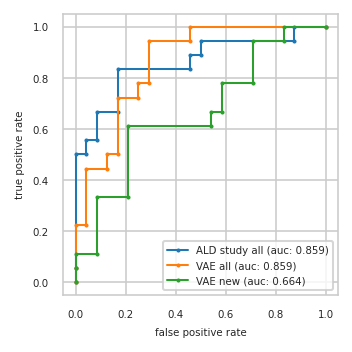

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.500   0.000 0.222   0.000 0.111
3          0.042 0.500   0.042 0.222   0.083 0.111
4          0.042 0.556   0.042 0.444   0.083 0.333
5          0.083 0.556   0.125 0.444   0.208 0.333
6          0.083 0.667   0.125 0.500   0.208 0.611
7          0.167 0.667   0.167 0.500   0.542 0.611
8          0.167 0.833   0.167 0.722   0.542 0.667
9          0.458 0.833   0.250 0.722   0.583 0.667
10         0.458 0.889   0.250 0.778   0.583 0.778
11         0.500 0.889   0.292 0.778   0.708 0.778
12         0.500 0.944   0.292 0.944   0.708 0.944
13         0.875 0.944   0.458 0.944   0.833 0.944
14         0.875 1.000   0.458 1.000   0.833 1.000
15         1.000 1.000   1.000 1.000   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01597;P04432,A0A0J9YXX1,H0Y7T8;P49418;P49418-2
2,D6RF86;P55285;P55285-2,A0A1W2PR05;A0A1W2PS68;Q07699;Q07699-2,Q9NUQ9
3,P61981,P63104,Q96GD0
4,P04075,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,Q02818,P61981,P31321
6,P14174,C9JF17;P05090,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P14618,P04075,J3KSJ8;Q9UD71;Q9UD71-2
8,P00338;P00338-3,P14174,Q9H741


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


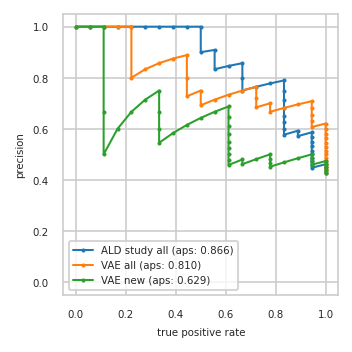

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.571 0.889     0.607 0.944     0.500 0.778
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.577 0.833     0.654 0.944     0.462 0.667
17         0.600 0.833     0.680 0.944     0.480 0.667
18         0.625 0.833     0.708 0.944     0.458 0.611
19         0.652 0.833     0.696 0.889     0.478 0.611
20         0.682 0.833     0.682 0.833     0.500 0.611
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.647 0.611
26         0.750 0.667     0.750 0.667     0.688 0.611
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


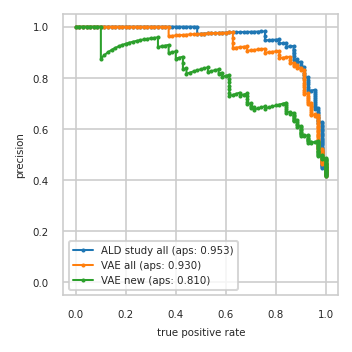

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


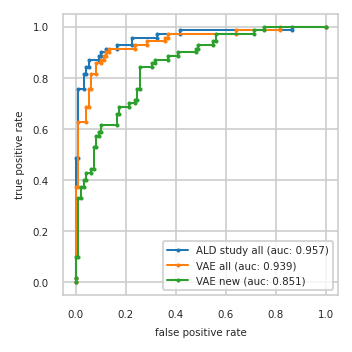

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}